In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install joblib

First few rows of the dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  

Missing values in each column:
step              0
type              0
am

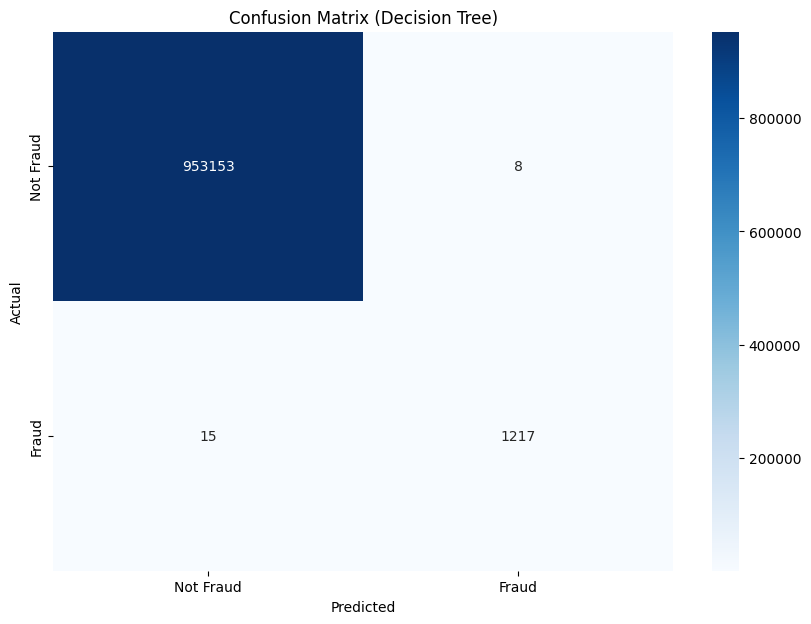

Model saved as decision_tree_model.pkl

Feature names used for training:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'errorBalanceOrig', 'errorBalanceDest']


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = '/kaggle/input/online-payment-fraud-detection/onlinefraud.csv'
dataset = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(dataset.head())

# Check for missing values
print("\nMissing values in each column:")
print(dataset.isnull().sum())

# If there were missing values, you could fill them like this:
# dataset.fillna(method='ffill', inplace=True)

# Feature Engineering
# One-hot encoding for 'type'
dataset = pd.get_dummies(dataset, columns=['type'], drop_first=True)

# Creating additional features
dataset['errorBalanceOrig'] = dataset['newbalanceOrig'] + dataset['amount'] - dataset['oldbalanceOrg']
dataset['errorBalanceDest'] = dataset['oldbalanceDest'] + dataset['amount'] - dataset['newbalanceDest']

# Dropping unnecessary columns
dataset.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# Normalizing numerical features
scaler = MinMaxScaler()
dataset[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']] = scaler.fit_transform(
    dataset[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']]
)

# Display the first few rows of the processed dataset
print("\nFirst few rows of the processed dataset:")
print(dataset.head())

# Splitting the data into features and target
X = dataset.drop(columns=['isFraud'])
y = dataset['isFraud']

# Split the data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')

# Decision Tree Model Training and Evaluation
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_val_pred_dt = dt_model.predict(X_val)
y_val_pred_proba_dt = dt_model.predict_proba(X_val)[:, 1]

# Evaluate the model
precision_dt = precision_score(y_val, y_val_pred_dt)
recall_dt = recall_score(y_val, y_val_pred_dt)
f1_dt = f1_score(y_val, y_val_pred_dt)
roc_auc_dt = roc_auc_score(y_val, y_val_pred_proba_dt)
conf_matrix_dt = confusion_matrix(y_val, y_val_pred_dt)

print(f'\nDecision Tree - Precision: {precision_dt:.4f}, Recall: {recall_dt:.4f}, F1-Score: {f1_dt:.4f}, ROC-AUC: {roc_auc_dt:.4f}')
print("\nConfusion Matrix (Decision Tree):")
print(conf_matrix_dt)
print("\nClassification Report (Decision Tree):")
print(classification_report(y_val, y_val_pred_dt))

# Save the confusion matrix as a PNG file
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_dt.png')
plt.show()

# Save the trained decision tree model
joblib.dump(dt_model, 'decision_tree_model.pkl')
print("Model saved as decision_tree_model.pkl")

# Print the feature names used for training
print("\nFeature names used for training:")
print(X.columns.tolist())
